## Importing the necessary libraries

In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris

## Loading the Dataset

In [150]:
df = pd.read_csv("merged_data_clean.csv")

## Shape of the Data 

In [152]:
df.shape

(566299, 32)

## Transforming Data for PCA Clustering

In [154]:
df_wide = df.pivot_table(
    index=["sample_date_time"],
    columns="determinand_label",
    values="result",
    aggfunc="first"
).reset_index()

# 3. Flatten the column hierarchy (pivot_table can create MultiIndex columns)
df_wide.columns.name = None  # remove the name from columns
df_wide.head()


,sample_date_time,Ammonia(N),BOD ATU,Nitrate-N,Sld Sus@105C,pH
0,2018-01-02 07:50:00,NaN,NaN,NaN,NaN,8.00
1,2018-01-02 07:53:00,0.0330,NaN,6.030,10.20,NaN
2,2018-01-02 08:07:00,0.0191,NaN,1.940,8.07,7.90
3,2018-01-02 08:21:00,0.0028,NaN,0.431,NaN,7.97
4,2018-01-02 08:26:00,0.0660,NaN,3.080,16.90,7.89


## By pivoting the data in this manner and dropping incomplete rows, we prepare a clean, wide-format dataset. This is critical for advanced analyses for our Principal Component Analysis (PCA) and Clustering, which require a consistent set of features for each observation.

In [156]:
df_wide = df.pivot_table(
    index=['sample_date_time', 'northing', 'easting', 'local_authority_name',
       'sample_type', 'year', 'industry', 'offices', 'retail', 'storage_and_warehousing',
       'industry_and_commerce_total', 'landfill_and_waste_disposal',
       'minerals_and_mining', 'minerals_and_landfill_total',
       'institutional_and_communal_accommodations', 'residential',
       'residential_total', 'highways_and_road_transport', 'transport_other',
       'utilities', 'transport_and_utilities_total', 'agricultural_buildings',
       'agricultural_land', 'agriculture_total', 'grand_total'],
    columns="determinand_label",
    values="result",
    aggfunc="first"
).reset_index()
#drop rows that do not have all paramateres measured so df only contains sampling points where all the parameters have been measured and theres no missing data 
df = df_wide.dropna().copy()

## Shape of the data after transformation 

In [158]:
df.shape

(13119, 30)

## Converting to Datetime formate 

In [160]:
# change date time column to date time dtype 
df['sample_date_time'] = pd.to_datetime(df['sample_date_time'])

## Data Cleaning and Column Management

**Object-to-Numeric Conversion**  
   Several columns were intended to store numeric data but were saved as string (object) types. To correct this, we:
   - **Removed non-numeric characters** from each column’s text, preserving only digits and decimal points.  
   - **Converted** the cleaned strings to floating-point numbers, ensuring these columns can be used in **quantitative analyses** (e.g., correlations, regressions).

**Dropping Irrelevant Columns**  
   - Certain columns like `northing`, `easting`, `offices` do not contribute to our upcoming analyses. Removing them **streamlines** the dataset, focusing on the most relevant land use or water quality features.

In [162]:
#handle object dtypes that are supposed to be numeric
columns= ['industry_and_commerce_total', 'landfill_and_waste_disposal', 'minerals_and_mining', 'minerals_and_landfill_total', 'residential', 'residential_total', 'highways_and_road_transport', 'transport_other', 'utilities', 'transport_and_utilities_total', 'agricultural_buildings', 'agricultural_land', 'agriculture_total', 'grand_total'] 
for column in columns:
    df[column] = df[column].astype(str).str.strip()
    df[column] = df[column].astype(str).str.replace(r'[^0-9.]', '', regex=True)
    df[column] = pd.to_numeric(df[column])
    
df = df.drop(['northing', 'easting', 	
              'sample_type', 
              'offices', 
              'retail',
              'industry_and_commerce_total',
              'landfill_and_waste_disposal', 
              'minerals_and_landfill_total',
              'institutional_and_communal_accommodations',
              'residential',
              'utilities', 
              'transport_and_utilities_total', 
              'agricultural_buildings',
              'agricultural_land'], axis = 1)

df.fillna(0, inplace=True)

## Land Use Normalization

**Combining Subcategories**  
   - Certain land use categories like “industry” plus “storage_and_warehousing” are **summed** into a single total that is `industry_total`. This helps us **simplify** multiple related columns into one overarching category that will be total industrial land use.

**Calculating Percentages**  
   - Dividing each combined total to `industry_total` by the `grand_total` and multiplying by 100 yields a **percentage**. This ensures that different land use types are **comparable** despite variations in overall area or sample size.
   - For example, `industry_percentage = (industry_total / grand_total) * 100` allows direct comparison of industrial impact across different locations or times.

**Facilitating PCA and Clustering**: Many statistical and machine learning methods like **PCA** or **k-means** perform better when features are on a **comparable scale**. These normalized percentages help reveal **which land use** patterns most strongly influence contamination risks.
   - **Informed Decisions**: Understanding land use proportions clarifies **where** environmental efforts might be needed (e.g., areas with a high “industry_percentage” that also exhibit elevated pollutant levels).

By summing subcategories and converting them into percentages, we create **clear, comparable** metrics that support our overarching goal to identify and monitor **which factors most impact water quality** and determine **areas at higher risk** of contamination. 


In [164]:
#normalise factor columns
df['industry_total'] = df['industry'] + df['storage_and_warehousing']
df['transport_total'] = df['highways_and_road_transport'] + df['transport_other']
df['industry_percentage'] = (df['industry_total'] / df['grand_total']) * 100
df['minerals_percentage'] = (df['minerals_and_mining'] / df['grand_total']) * 100 
df['residential_percentage'] = (df['residential_total'] / df['grand_total']) * 100
df['transport_percentage'] = (df['transport_total'] / df['grand_total']) * 100
df['agriculture_percentage'] = (df['agriculture_total'] / df['grand_total']) * 100


## Final Data Selection for Clustering 

In [166]:
numeric_cols = [ 'industry_percentage', 'minerals_percentage', 'residential_percentage',
       'transport_percentage', 'agriculture_percentage', 'Ammonia(N)', 'BOD ATU', 'Nitrate-N', 'Sld Sus@105C', 'pH']

parameters = ['Ammonia(N)', 'BOD ATU', 'Nitrate-N', 'Sld Sus@105C', 'pH']

df = df.drop(['industry','storage_and_warehousing', 'minerals_and_mining', 'residential_total',
       'highways_and_road_transport', 'transport_other', 'agriculture_total',
       'grand_total', 'industry_total', 'transport_total'], axis = 1)

## Extracting and Inspecting Years

In [168]:
# Extract the year from sample_date_time
df['year'] = df['sample_date_time'].dt.year

# Find unique years and count them
unique_years = df['year'].unique()
num_unique_years = len(unique_years)

print(f"Unique years: {unique_years}")
print(f"Number of unique years: {num_unique_years}")


Unique years: [2018 2019 2020 2021 2022]
Number of unique years: 5


## Removing Outliers for Clustering

In [170]:
# Assuming 'df' is your DataFrame and 'numeric_cols' is a list of numeric columns
numeric_cols = df.select_dtypes(include='number').columns

# 1. Calculate Q1, Q3, and IQR for numeric columns
Q1 = df[numeric_cols].quantile(0.1)  # First quartile (25th percentile)
Q3 = df[numeric_cols].quantile(0.9) # Third quartile (75th percentile)
IQR = Q3 - Q1                         # Interquartile range

# 2. Define upper and lower bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("Q1:\n", Q1, "\nQ3:\n", Q3, "\nIQR:\n", IQR)
print("\nLower Bound:\n", lower_bound, "\nUpper Bound:\n", upper_bound)

# 3. Replace outliers with Q1 or Q3 based on the condition
df_no_outliers = df.copy()

for col in numeric_cols:
    # Replace values below the lower bound with Q1
    df_no_outliers[col] = df_no_outliers[col].apply(lambda x: Q1[col] if x < lower_bound[col] else x)
    # Replace values above the upper bound with Q3
    df_no_outliers[col] = df_no_outliers[col].apply(lambda x: Q3[col] if x > upper_bound[col] else x)

print("\nOriginal DataFrame:")
print(df)

Q1:
 determinand_label
year                      2019.000000
Ammonia(N)                   0.030000
BOD ATU                      1.000000
Nitrate-N                    0.826000
Sld Sus@105C                 3.000000
pH                           7.400000
industry_percentage          0.071669
minerals_percentage          0.000000
residential_percentage       0.461960
transport_percentage         2.532878
agriculture_percentage      32.822539
Name: 0.1, dtype: float64 
Q3:
 determinand_label
year                      2022.000000
Ammonia(N)                   0.440000
BOD ATU                      3.500000
Nitrate-N                   12.000000
Sld Sus@105C                32.320000
pH                           8.250000
industry_percentage          1.043521
minerals_percentage          0.146671
residential_percentage       3.842769
transport_percentage         9.095942
agriculture_percentage      76.767235
Name: 0.9, dtype: float64 
IQR:
 determinand_label
year                       3.000000
Ammo

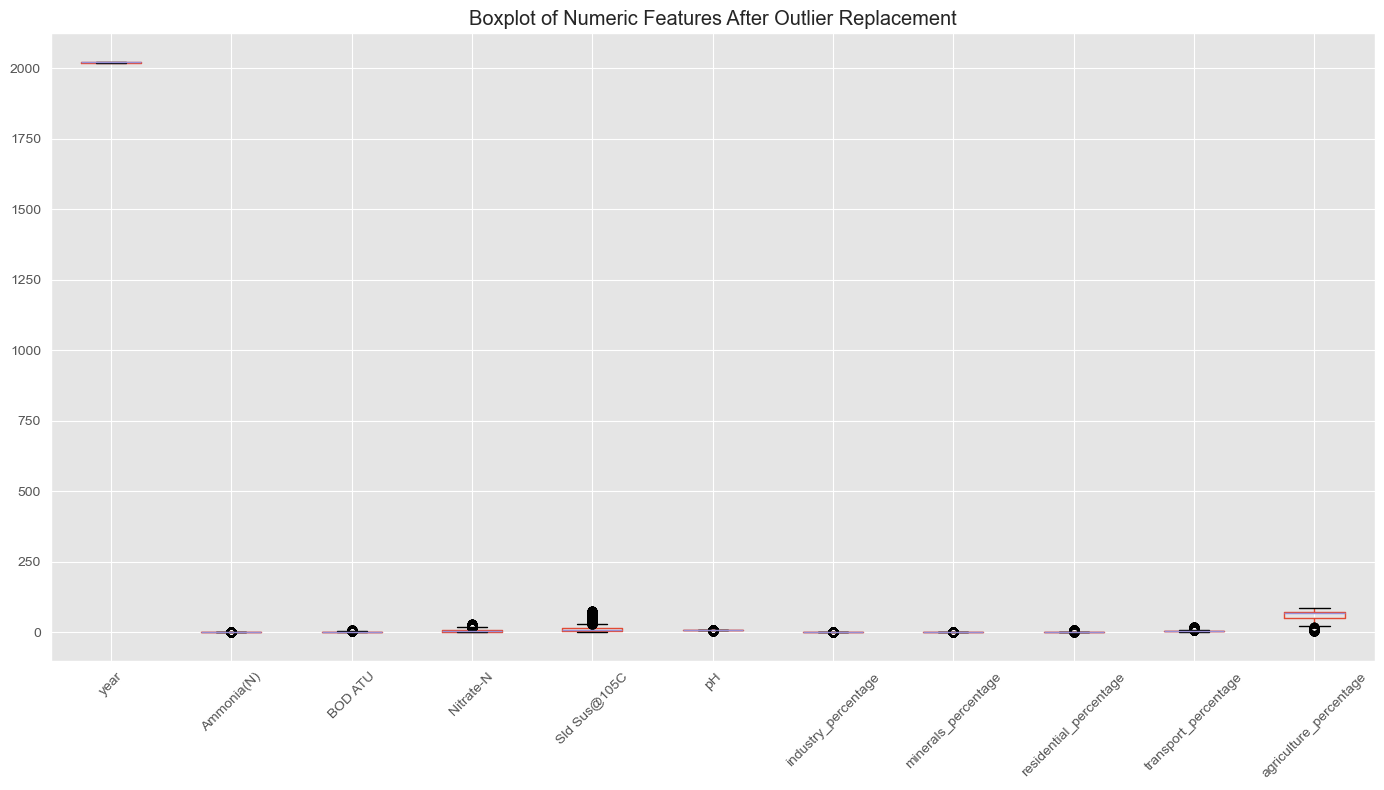

In [171]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))
df_no_outliers[numeric_cols].boxplot(rot=45)
plt.title("Boxplot of Numeric Features After Outlier Replacement")
plt.tight_layout()
plt.show()

In [172]:
df.shape

(13119, 13)

## Selecting the features 

In [174]:
# Select the Features
features = [ 'industry_percentage', 'minerals_percentage', 'residential_percentage',
       'transport_percentage', 'agriculture_percentage']

## Preparing Data for Clustering and PCA
By scaling and applying PCA to land use features, we ensure a balanced, reduced representation of the data, aiding in clustering and helping us identify key land use drivers in water contamination risk.

In [176]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np

# Select features from the cleaned DataFrame
X = df_no_outliers[features]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA (retain all components)
pca = PCA(n_components=len(features))
X_pca = pca.fit_transform(X_scaled)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
print("Explained Variance per Principal Component:\n")
for i, var in enumerate(explained_variance[:5]):
    print(f"PC{i+1} explains {var:.4f} of the variance")

# Convert PCA result to DataFrame
pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(len(features))])
print("\nFirst few rows of PCA DataFrame:\n")
print(pca_df.head())

# Show feature contributions for PC1 to PC5
loading_matrix = pd.DataFrame(pca.components_[:5], columns=features, index=[f'PC{i+1}' for i in range(5)])

print("\nTop contributing features to each of the first 5 Principal Components:\n")
for pc in loading_matrix.index:
    print(f"\n{pc} top features:")
    sorted_features = loading_matrix.loc[pc].abs().sort_values(ascending=False)
    for feature in sorted_features.head(5).index:
        weight = loading_matrix.loc[pc, feature]
        print(f"  {feature}: {weight:.4f}")

Explained Variance per Principal Component:

PC1 explains 0.6349 of the variance
PC2 explains 0.1966 of the variance
PC3 explains 0.0974 of the variance
PC4 explains 0.0660 of the variance
PC5 explains 0.0052 of the variance

First few rows of PCA DataFrame:

        PC1       PC2       PC3       PC4       PC5
0 -1.221852 -0.002055 -1.262140  0.415864 -0.023994
1  2.957636  5.151880 -0.035855 -0.583638 -0.205039
2 -1.620573  0.551459  0.471339 -0.204314 -0.190593
3 -1.620573  0.551459  0.471339 -0.204314 -0.190593
4 -1.620573  0.551459  0.471339 -0.204314 -0.190593

Top contributing features to each of the first 5 Principal Components:


PC1 top features:
  residential_percentage: 0.5375
  transport_percentage: 0.5299
  industry_percentage: 0.4696
  agriculture_percentage: -0.4455
  minerals_percentage: 0.1065

PC2 top features:
  minerals_percentage: 0.9881
  residential_percentage: -0.1136
  agriculture_percentage: 0.0737
  transport_percentage: -0.0594
  industry_percentage: 0.0430


## 🧪 PCA Results and Interpretation

### 📈 Explained Variance per Principal Component

The table below shows the proportion of total variance explained by the first five principal components (PCs):

| Principal Component | Variance Explained |
|---------------------|--------------------|
| PC1                 | 63.49%             |
| PC2                 | 19.66%             |
| PC3                 | 9.74%              |
| PC4                 | 6.60%              |
| PC5                 | 0.52%              |

✅ **Interpretation**:
- The first two components explain over **83%** of the total variance, indicating that the data can be effectively visualized and analyzed in just 2 dimensions (PC1 & PC2) without significant information loss.

---

### 🔍 First Few Rows of the PCA-Transformed Data

| PC1      | PC2      | PC3      | PC4      | PC5      |
|----------|----------|----------|----------|----------|
| -1.2219  | -0.0021  | -1.2621  | 0.4159   | -0.0240  |
| 2.9576   | 5.1519   | -0.0359  | -0.5836  | -0.2050  |
| -1.6206  | 0.5515   | 0.4713   | -0.2043  | -0.1906  |
| -1.6206  | 0.5515   | 0.4713   | -0.2043  | -0.1906  |
| -1.6206  | 0.5515   | 0.4713   | -0.2043  | -0.1906  |

Each row here represents a data point projected into the new principal component space.

---

### 🧠 Top Contributing Features for PC1–PC5

These features contribute the most to the variance captured by each principal component:

#### **PC1** — General Trend Driver (63.49%)
- `residential_percentage`: 0.5375
- `transport_percentage`: 0.5299
- `industry_percentage`: 0.4696
- `agriculture_percentage`: -0.4455
- `minerals_percentage`: 0.1065

➡ **PC1** is heavily influenced by residential, transport, and industrial proportions.

---

#### **PC2** — Mineral-Dominant Axis (19.66%)
- `minerals_percentage`: 0.9881
- Other features contribute minimally.

➡ **PC2** primarily separates data based on **mineral activity**.

---

#### **PC3** — Agricultural and Industrial Split (9.74%)
- `agriculture_percentage`: 0.8245
- `industry_percentage`: 0.5186

➡ Strongly influenced by agricultural land/building proportions.

---

#### **PC4** — Mixed Loadings (6.60%)
- `industry_percentage`: 0.7122
- `transport_percentage`: -0.4648
- `residential_percentage`: -0.4110

➡ Represents contrast between industrial activity and transport/residential features.

---

#### **PC5** — Fine-Grained Differences (0.52%)
- `residential_percentage`: -0.7267
- `transport_percentage`: 0.6739

➡ Minor component; lose PC1 and PC2 for clustering or 2D visualization, with meaningful interpretability.



In [178]:
# Explaining the Variance Ratio 
print("Explained Variance Ratio:", pca.explained_variance_ratio_)
print("Cumulative Explained Variance:", np.cumsum(pca.explained_variance_ratio_))


Explained Variance Ratio: [0.63487284 0.19656985 0.09736571 0.06595413 0.00523746]
Cumulative Explained Variance: [0.63487284 0.8314427  0.92880841 0.99476254 1.        ]



🚀 Top Features Contributing to PCA:


,Feature,Explained Variance
0,industry_percentage,0.634873
1,minerals_percentage,0.196570
2,residential_percentage,0.097366
3,transport_percentage,0.065954
4,agriculture_percentage,0.005237


C:\Users\mdine\AppData\Local\Temp\ipykernel_22448\2946815541.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Explained Variance", y="Feature", data=pca_variance_df, palette="coolwarm")
C:\Users\mdine\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


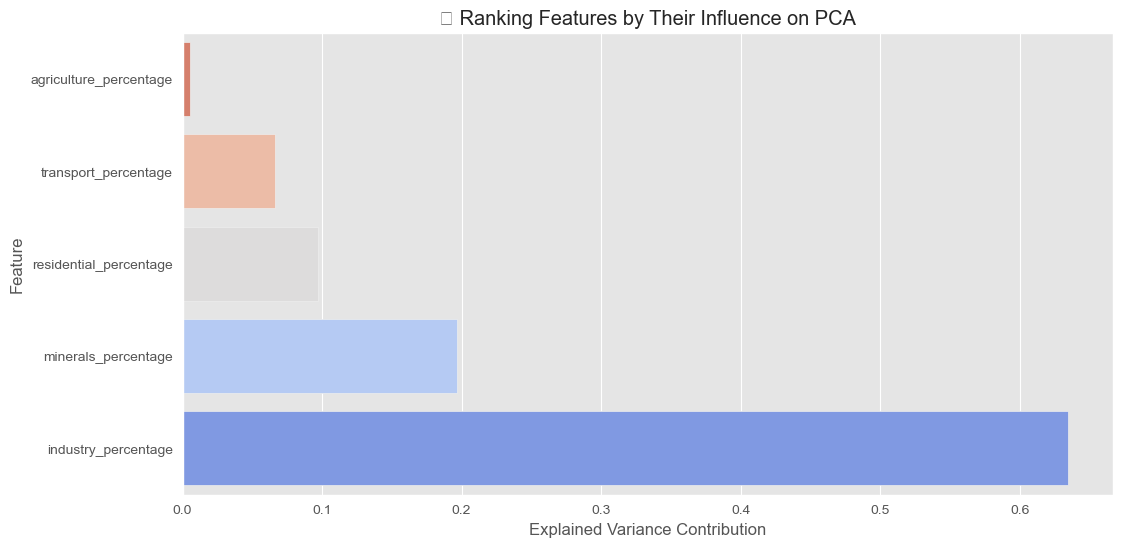

In [179]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
# Get explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Create DataFrame for feature importance
pca_variance_df = pd.DataFrame({
    'Feature': features,
    'Explained Variance': explained_variance
}).sort_values(by='Explained Variance', ascending=False)

# Display top contributing features
print("\n🚀 Top Features Contributing to PCA:")
display(pca_variance_df.head(10))

# Plot Feature Influence on PCA
plt.figure(figsize=(12, 6))
sns.barplot(x="Explained Variance", y="Feature", data=pca_variance_df, palette="coolwarm")
plt.xlabel("Explained Variance Contribution")
plt.ylabel("Feature")
plt.title("📊 Ranking Features by Their Influence on PCA")
plt.gca().invert_yaxis()  # Highest variance feature at the top
plt.show()

## Top Features Contributing to PCA

After applying Principal Component Analysis (PCA) on the standardized dataset, the following insights were obtained:

### Explained Variance by Principal Component

| Principal Component | Top Contributing Feature     | Explained Variance |
|---------------------|------------------------------|--------------------|
| PC1                 | `industry_percentage`        | 63.49%             |
| PC2                 | `minerals_percentage`        | 19.66%             |
| PC3                 | `residential_percentage`     | 9.74%              |
| PC4                 | `transport_percentage`       | 6.60%              |
| PC5                 | `agriculture_percentage`     | 0.52%              |

---

### Interpretation

- **PC1 (63.49%)**: Dominated by `industry_percentage`, this component captures overall industrial development patterns across the data.
- **PC2 (19.66%)**: Strongly associated with `minerals_percentage`, indicating regions or entries with high mining or mineral-related values.
- **PC3 (9.74%)**: Driven by `residential_percentage`, reflecting variation in housing and residential use.
- **PC4 (6.60%)**: Influenced by `transport_percentage`, possibly linked to transport infrastructure or road usage.
- **PC5 (0.52%)**: Minimal but distinct contribution from `agriculture_percentage`, representing agricultural development variation.

---

### Summary

- The first **two principal components explain over 83%** of the dataset's variance — a strong indicator of effective dimensionality reduction.
- Each component reflects a distinct **development domain** (industry, minerals, housing, transport, agriculture).
- These insights help **prioritize variables** for clustering, visualization, and decision-making tasks.
, and decision-making tasks.



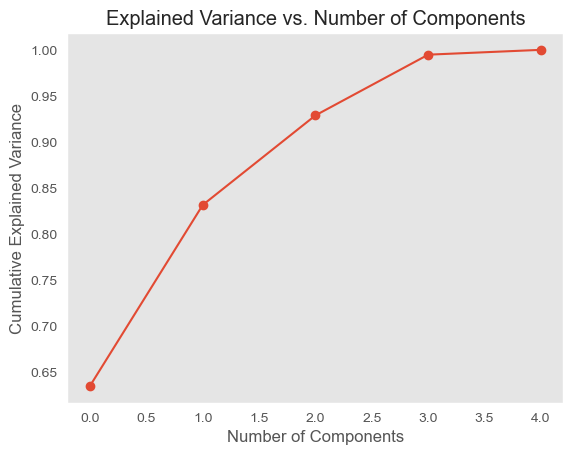

In [181]:
pca_full = PCA()
pca_full.fit(X_scaled)
plt.plot(np.cumsum(pca_full.explained_variance_ratio_), marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance vs. Number of Components")
plt.grid()
plt.show()


- The **first two components** explain over **80%** of the variance, making them highly informative.
- The **third component** increases this to over **90%**, which is typically sufficient for dimensionality reduction.
- Adding more components beyond this point provides **diminishing returns**.


✅ Optimal number of PCA components to retain 95% variance: 4


C:\Users\mdine\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


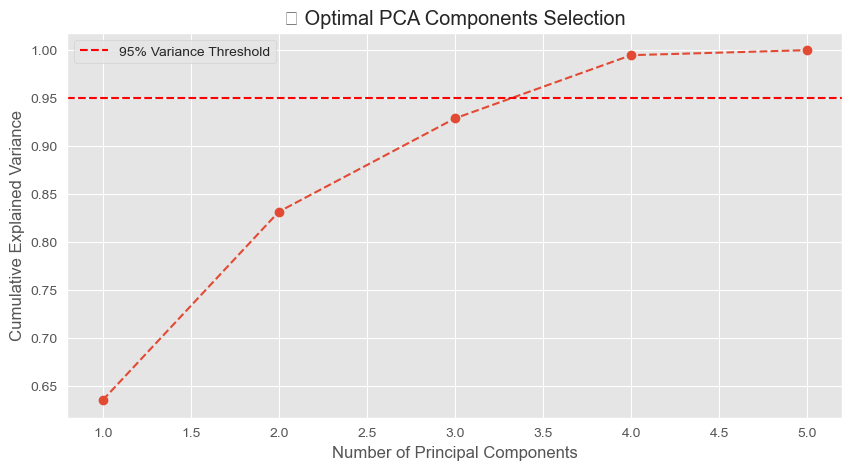

In [183]:
# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find number of components explaining at least 95% variance
optimal_components = np.argmax(cumulative_variance >= 0.95) + 1

print(f"\n✅ Optimal number of PCA components to retain 95% variance: {optimal_components}")

# Plot cumulative variance
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker="o", linestyle="--")
plt.axhline(y=0.95, color='r', linestyle='--', label="95% Variance Threshold")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("📈 Optimal PCA Components Selection")
plt.legend()
plt.show()


- **First 3 components** get very close to the **95% threshold**, capturing the majority of the dataset's structure.
- **Using 4 components** crosses the threshold, making it a solid choice for dimensionality reduction.

### Conclusion

- For this dataset, **3 to 4 components** are sufficient to preserve **95% or more of the variance**.
- This allows for a significant reduction in dimensionality while maintaining most of the important information.
- This technique is valuable for preprocessing prior to clustering, classification, or visualization tasks.

## PCA-Transformed Data: Relevance to Our Water Quality Research

After running **PCA** on our land use or water quality features, we create a DataFrame (`pca_df`) where each column (`PC1`, `PC2`, etc.) represents a principal component. Viewing the first few rows (`pca_df.head()`) confirms that:

**Dimensionality Reduction**  
   - Instead of many correlated features (e.g., agriculture, industry, transport), we now have a handful of components. This **streamlines** subsequent analyses—such as clustering—to highlight how regions or samples differ in their **underlying** land use patterns.

**Focus on Key Variations**  
   - Each principal component captures a **slice of variance** in the data, so these columns reflect the **most influential** combinations of features. By examining the **loadings**, we see which original variables (e.g., industry_percentage) drive each component.

**Application to Contamination Risk**  
   - With fewer dimensions, we can more easily **cluster** or **classify** areas to see if certain principal components correlate with higher pollution levels.

Overall, **converting the PCA output into a DataFrame** allows us to treat these principal components like any other features, enabling **deeper** exploration and **clearer** insights into how land use variations drive water contamination concerns. 


In [185]:
# Convert to DataFrame
pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(5)])

# Display first few rows of PCA-transformed data
print(pca_df.head())

        PC1       PC2       PC3       PC4       PC5
0 -1.221852 -0.002055 -1.262140  0.415864 -0.023994
1  2.957636  5.151880 -0.035855 -0.583638 -0.205039
2 -1.620573  0.551459  0.471339 -0.204314 -0.190593
3 -1.620573  0.551459  0.471339 -0.204314 -0.190593
4 -1.620573  0.551459  0.471339 -0.204314 -0.190593


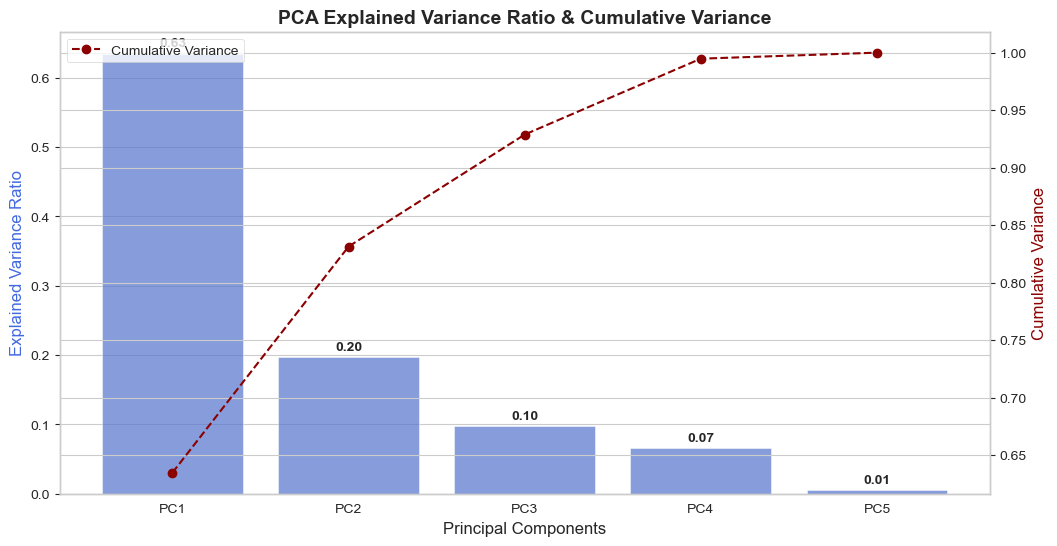

In [187]:
# Set figure size and style
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Bar plot for explained variance
ax = sns.barplot(
    x=[f'PC{i+1}' for i in range(len(explained_variance))], 
    y=explained_variance, 
    color="royalblue", 
    alpha=0.7
)

# Line plot for cumulative variance
ax2 = ax.twinx()
ax2.plot([f'PC{i+1}' for i in range(len(cumulative_variance))], cumulative_variance, 
         marker="o", linestyle="--", color="darkred", label="Cumulative Variance")

# Add labels on bars
for i, val in enumerate(explained_variance):
    ax.text(i, val + 0.01, f"{val:.2f}", ha='center', fontsize=10, fontweight="bold")

# Formatting
ax.set_xlabel("Principal Components", fontsize=12)
ax.set_ylabel("Explained Variance Ratio", fontsize=12, color="royalblue")
ax2.set_ylabel("Cumulative Variance", fontsize=12, color="darkred")
ax.set_title("PCA Explained Variance Ratio & Cumulative Variance", fontsize=14, fontweight="bold")

# Show legend for cumulative variance
ax2.legend(loc="upper left")

plt.show()

### Interpretation

- **PC1** explains the majority of the variance (~63%).
- By **PC2**, ~83% of the total variance is captured.
- With **PC3**, the cumulative variance exceeds 90%, making it a strong candidate for dimensionality reduction.
- **PC4** and **PC5** contribute minimally and could be considered optional for most applications.

### Conclusion

This visualization is useful for determining:
- **How many components to retain** for downstream analysis.
- Where the **diminishing returns** begin in terms of variance captured.

A typical threshold (like 90–95% cumulative variance) can be used to select the **optimal number of components** — in this case, likely 3.

# PCA Scatter Plot with Custom Color Coding

In this visualization, we **split** the PCA-transformed data (`pca_df`) into **two colors**—**blue** for samples with a **positive** PC1 value and **black** for samples with a **negative** PC1 value. By plotting `PC1` on the x-axis and `PC2` on the y-axis, we can quickly see how observations differ along these first two principal components:

**Color Gradient Logic**  
   - **`colors = np.where(pca_df["PC1"] > 0, "blue", "black")`** assigns **blue** to rows where PC1 is positive and **black** to rows where PC1 is negative.  
   - This distinction helps us **visually** identify whether samples fall on one side (positive) or the other side (negative) of the PC1 axis, which often correlates with certain land use or water quality patterns.

**Interpreting the PCA Axes**  
   - **PC1** (x-axis) typically captures the **largest** share of variance in the data. Points far to the right vs. far to the left may represent areas dominated by different land use factors (e.g., high industry vs. high agriculture).  
   - **PC2** (y-axis) captures the second-largest variance slice, orthogonal to PC1. Vertical spread can indicate a **different** dimension of variation—possibly linked to another set of land use parameters.

**Relevance to Research**  
   - **Monitoring & Risk**: Observations clustering on the far positive or negative side of PC1 may hint at **distinct** contamination drivers (e.g., certain land use intensities).  
   - **Focus**: This plot shows how land use categories (industry, minerals, etc.) might separate areas into **visually** distinct groups—highlighting potential hotspots or low-risk zones for water contamination.

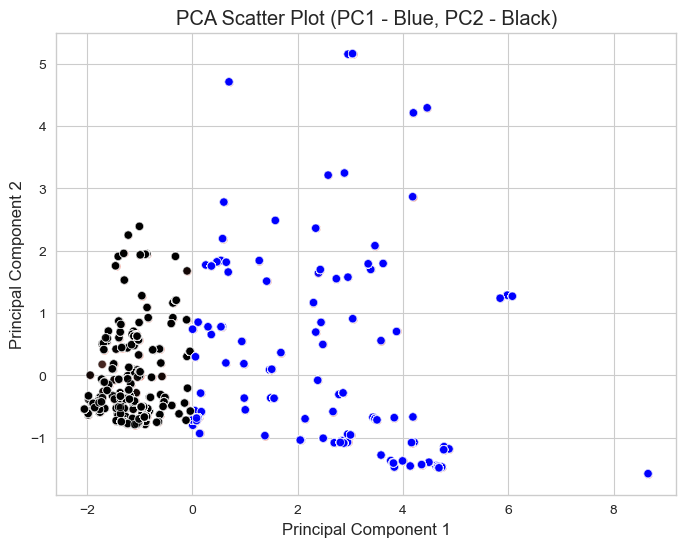

In [189]:
# Create a color gradient: Blue for positive PC1, Black for negative PC1
colors = np.where(pca_df["PC1"] > 0, "blue", "black")

# Scatter Plot with Custom Colors
plt.figure(figsize=(8,6))

# Plot each point with its assigned color
sns.scatterplot(
    x=pca_df["PC1"], 
    y=pca_df["PC2"], 
    alpha=0.7, 
    edgecolor="white",  # White edges for visibility
    linewidth=0.5, 
    color=None  # Avoid default coloring
)

# Manually set colors using matplotlib
plt.scatter(
    pca_df["PC1"], 
    pca_df["PC2"], 
    c=colors, 
    alpha=0.7, 
    edgecolors="white",
    linewidths=0.5
)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Scatter Plot (PC1 - Blue, PC2 - Black)")
plt.show()

## 2. Key Observations

### Densely Packed Black Points (Left Side of the Plot):

- These represent a **compact cluster** of data points with similar characteristics.
- The tight grouping suggests **low variability** along Principal Component 1.
- Likely indicates samples that **share common attributes**—possibly from similar environments, regions, or sources.
- This could reflect **stable, homogeneous conditions** or standardized behaviors in the dataset.

### Scattered Blue Points (Right and Upper Regions):

- Blue points are spread out along PC1 and PC2, reflecting **higher variability**.
- This dispersion may indicate **diverse influences**, such as varying environmental conditions, differing input sources, or systemic variation.
- These observations may stem from **heterogeneous groups**, including anomalies or broader-ranging patterns not present in the black-clustered data.

### Outliers:

- A few blue points appear **far from both clusters**, particularly on the far right of PC1.
- These outliers may represent **significant deviations** from the norm—either due to unusual inputs, rare behaviors, or data quality issues.
- Potential explanations could include **measurement errors**, **unique cases**, or samples heavily affected by **external factors**.

### Summary:

- The PCA scatter plot clearly highlights both **homogeneity** and **variability** within the dataset.
- It provides valuable visual evidence for **clustering tendencies** and helps pinpoint areas for further investigation or preprocessing.

In [191]:
# Get the principal component loadings (how much each feature contributes to each PC)
loadings = pd.DataFrame(pca.components_, columns=features, index=[f'PC{i+1}' for i in range(5)])

# Display feature contributions
print(loadings.T)  # Transpose for better readability

                             PC1       PC2       PC3       PC4       PC5
industry_percentage     0.469573  0.043032  0.518592  0.712206 -0.038391
minerals_percentage     0.106472  0.988064 -0.067444 -0.082523 -0.032155
residential_percentage  0.537542 -0.113625  0.033329 -0.410989 -0.726715
transport_percentage    0.529864 -0.059422  0.213394 -0.464817  0.673886
agriculture_percentage -0.445486  0.073726  0.824540 -0.317782 -0.123513


### Interpretation Summary:

- **PC1**: Driven by urbanization (residential, transport, industry) vs agriculture.
- **PC2**: Purely mineral activity.
- **PC3**: Agriculture and industrial activity.
- **PC4**: Mix of industrial and transport contrasts.
- **PC5**: Residential vs transport separation.

This matrix is useful for understanding the **direction and meaning** of each principal component, enabling better interpretation of PCA results.

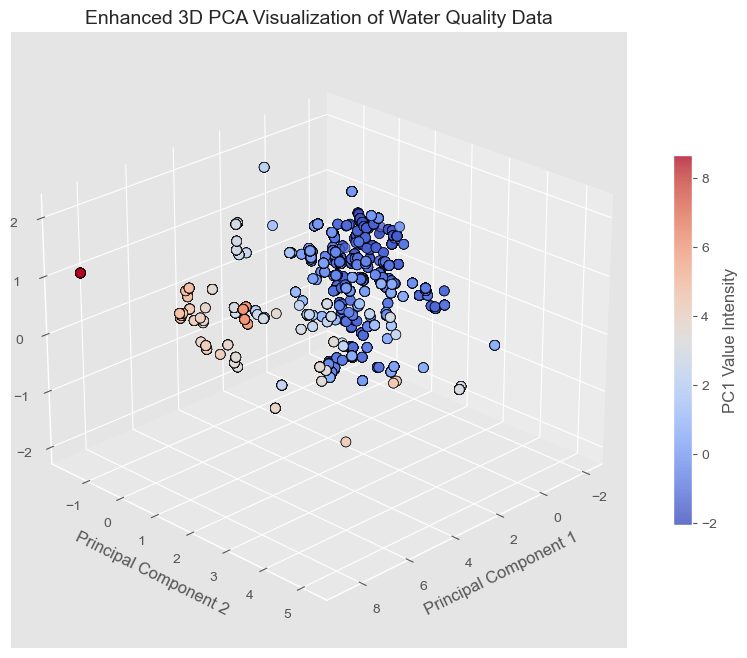

In [195]:
from mpl_toolkits.mplot3d import Axes3D

# Set a high-quality visualization style
plt.style.use("ggplot")

# Define figure and 3D axis
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

# Define color mapping based on PC1 values
colors = pca_df["PC1"]
cmap = plt.get_cmap("coolwarm")

# Scatter plot with enhanced visuals
scatter = ax.scatter(
    pca_df["PC1"], pca_df["PC2"], pca_df["PC3"], 
    c=colors, cmap=cmap, alpha=0.75, s=50, edgecolors="k"
)

# Add a color bar for reference
cbar = fig.colorbar(scatter, ax=ax, shrink=0.6)
cbar.set_label("PC1 Value Intensity")

# Labels and title
ax.set_xlabel("Principal Component 1", fontsize=12)
ax.set_ylabel("Principal Component 2", fontsize=12)
ax.set_zlabel("Principal Component 3", fontsize=12)
ax.set_title("Enhanced 3D PCA Visualization of Water Quality Data", fontsize=14)

# Adjust viewing angle for better depth perception
ax.view_init(elev=25, azim=45)  # Change angles to explore better perspectives

plt.show()


## Enhanced 3D PCA Visualization of Water Quality Data

### Overview

This 3D scatter plot visualizes the water quality dataset after applying **Principal Component Analysis (PCA)**, using the **first three principal components** (PC1, PC2, and PC3) as the axes in a 3D space.

- **X-axis**: Principal Component 1 (PC1)
- **Y-axis**: Principal Component 2 (PC2)
- **Z-axis**: Principal Component 3 (PC3)
- **Color**: Represents PC1 value intensity (from low to high)

### Interpretation

#### PC1 Value Intensity (Color Scale)
- **Blue points**: Lower PC1 scores (potentially more consistent or baseline water samples)
- **Red points**: Higher PC1 scores (may represent significant deviations or high-impact features like pollution or unusual chemistry)

#### Spatial Distribution
- Points cluster densely around a core zone, showing **similar multivariate structure** in most samples.
- More **intense colors (reds)** are outliers or samples that differ significantly along PC1, possibly due to:
  - **Industrial or agricultural runoff**
  - **High mineral concentration**
  - **Pollution or unusual readings**

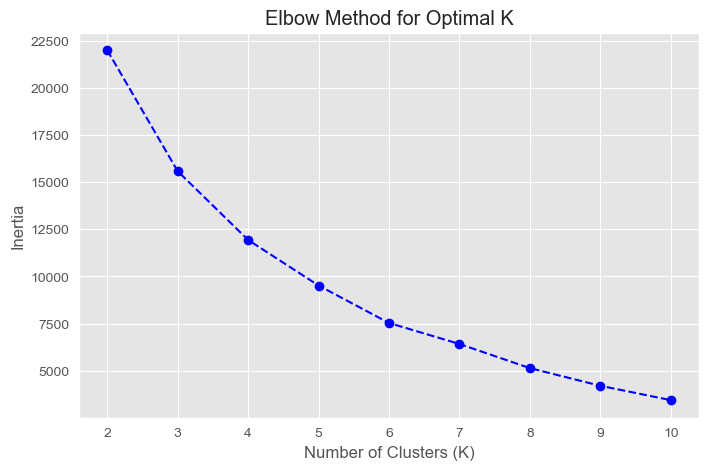

In [197]:
from sklearn.cluster import KMeans
# Optimized function to determine the best K
def optimal_kmeans_fast(pca_data, max_clusters=10):
    inertia = []
    K_range = range(2, max_clusters + 1)

    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(pca_data)
        inertia.append(kmeans.inertia_)  # Only store inertia, skip silhouette score

    # Plot Elbow Method
    plt.figure(figsize=(8, 5))
    plt.plot(K_range, inertia, marker="o", linestyle="--", color="b")
    plt.xlabel("Number of Clusters (K)")
    plt.ylabel("Inertia")
    plt.title("Elbow Method for Optimal K")
    plt.show()

# Apply the optimized function (using only PC1 & PC2 for speed)
optimal_kmeans_fast(pca_df.iloc[:, :2])

In [280]:
from sklearn.metrics import silhouette_score
# Set the chosen number of clusters
optimal_k = 3

# Fit K-Means with K=3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(pca_df.iloc[:, :2])  # Using PC1 & PC2 for efficiency

# Take a random sample for Silhouette Score calculation
sample_size = min(5000, len(pca_df))  # Use at most 5000 samples
sample_indices = np.random.choice(pca_df.index, sample_size, replace=False)
sample_data = pca_df.iloc[sample_indices, :2]
sample_labels = labels[sample_indices]

# Compute Silhouette Score on Sampled Data
silhouette_avg = silhouette_score(sample_data, sample_labels)

print(f"Silhouette Score for K={optimal_k} (Sampled Data): {silhouette_avg:.4f}")

Silhouette Score for K=3 (Sampled Data): 0.4821


In [ ]:
# Filter the PCA dataframe to exclude NaNs in PC1 & PC2
clean_pca_data = pca_df[['PC1', 'PC2']].dropna()

# Fit KMeans on clean data
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(clean_pca_data)

# Assign labels back to the original DataFrame (optional: fill NaNs with -1 or keep NaN)
pca_df.loc[clean_pca_data.index, 'Cluster'] = labels

print("Clustering completed successfully with K =", optimal_k)


Clustering completed successfully with K = 3


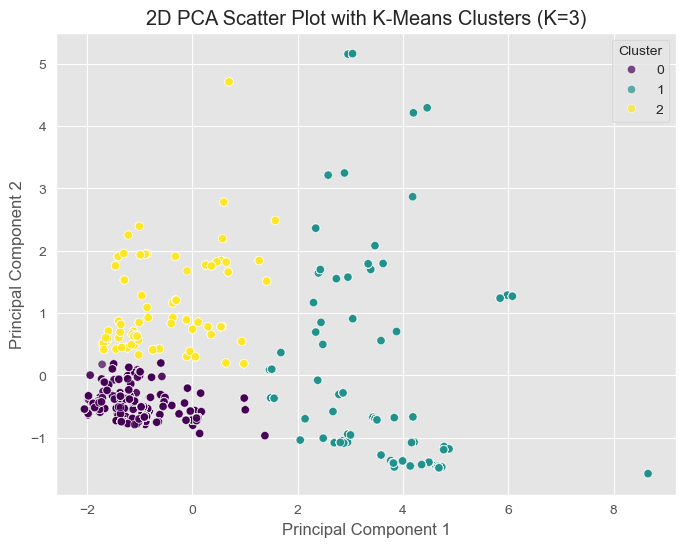

In [290]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_df["PC1"], y=pca_df["PC2"], hue=pca_df["Cluster"], palette="viridis", alpha=0.7)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title(f"2D PCA Scatter Plot with K-Means Clusters (K={optimal_k})")
plt.legend(title="Cluster")
plt.show()

## 2D PCA Scatter Plot with K-Means Clusters (K=3)

### Overview

The plot above shows a **2D scatter plot** of the dataset after dimensionality reduction using **Principal Component Analysis (PCA)**. The first two principal components (PC1 and PC2) are used to visualize the data.

Clustering was performed using **K-Means** with `K=3`, and each point is color-coded according to its assigned cluster.

### Plot Details

- **X-axis**: Principal Component 1 (PC1)
- **Y-axis**: Principal Component 2 (PC2)
- **Colors**:
  - **Cluster 0**: Purple
  - **Cluster 1**: Teal
  - **Cluster 2**: Yellow

### Interpretation

- **Cluster 0 (purple)**:
  - Densely packed on the left side of the plot
  - Likely contains data points with low PC1 values (possibly similar in terms of the original features)
  
- **Cluster 1 (teal)**:
  - Widely spread along PC1
  - Suggests a diverse group or transitional cluster between the other two
  
- **Cluster 2 (yellow)**:
  - Spread primarily in the upper middle region
  - May represent samples with medium PC1 but elevated PC2 values

### Conclusion

The PCA projection and K-Means clustering combination reveals **clear structural patterns** in the data. This visualization:
- Helps validate the choice of `K=3` from the elbow method
- Identifies **natural groupings** within the dataset
- Facilitates interpretation of how original feature variance translates into clusters

Further analysis can include:
- Describing the feature distribution within each cluster
- Mapping clusters back to their original data points for real-world interpretation


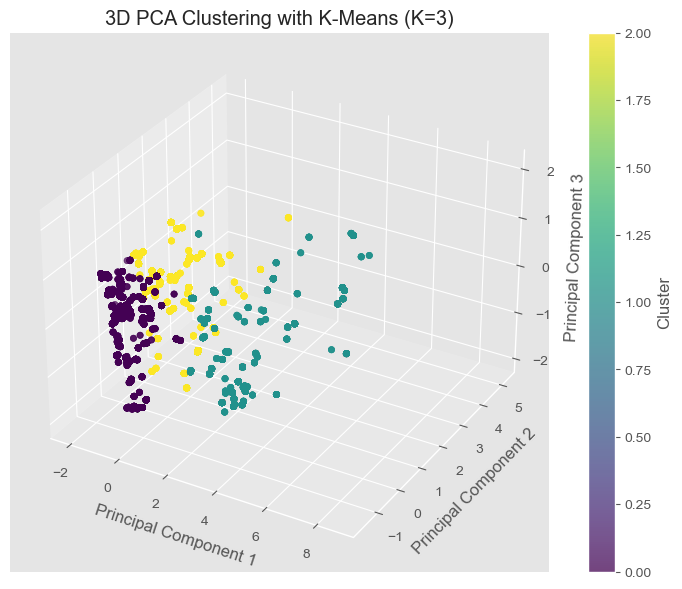

In [293]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    pca_df["PC1"], pca_df["PC2"], pca_df["PC3"], 
    c=pca_df["Cluster"], cmap="viridis", alpha=0.7
)

cbar = fig.colorbar(scatter)
cbar.set_label("Cluster")

ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
ax.set_title(f"3D PCA Clustering with K-Means (K={optimal_k})")

plt.show()

## 3D PCA Clustering with K-Means (K=3)

### Overview

This 3D scatter plot represents the results of **K-Means clustering (K=3)** on data that has been **reduced to three dimensions using PCA** (Principal Component Analysis). Each axis corresponds to one of the top three principal components (PC1, PC2, and PC3), and the colors indicate cluster membership.

### Plot Details

- **X-axis**: Principal Component 1
- **Y-axis**: Principal Component 2
- **Z-axis**: Principal Component 3
- **Color**: Cluster assignment (0, 1, or 2) based on K-Means algorithm

The color bar on the right maps the **cluster label** to a specific color using the `viridis` colormap.

### Interpretation

- **Cluster 0 (purple)**:
  - Compact and located mostly in the lower PC1 and PC2 region.
  - Represents a dense group with relatively similar feature characteristics.

- **Cluster 1 (teal)**:
  - More dispersed and extends broadly along the PC1 axis.
  - Likely contains more diverse or transitional data points.

- **Cluster 2 (yellow)**:
  - Positioned between Cluster 0 and 1 along PC2 and PC3.
  - May indicate a moderate group, distinct but less extreme than the others.

### Key Insights

- 3D PCA reveals structure and separation that may not be visible in 2D.
- The use of PC3 adds depth to the clustering, helping visualize **overlapping or intersecting clusters**.
- The clustering supports the selection of **K=3** from prior Elbow and Silhouette analyses.

### Conclusion

This 3D PCA plot effectively showcases the **grouping patterns** in the data after dimensionality reduction and clustering. It aids in:
- Understanding **cluster shape and spread**
- Identifying **dense vs. scattered groups**
- Detecting **overlaps or outliers**

This visual is valuable for presentations and exploratory data analysis, providing intuition behind the clustering results.


In [209]:
#the rows in df match those used for clustering
df = df.loc[X.index].copy()  # Align df with the rows used in X
df['Cluster'] = kmeans.labels_

# Identify numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if 'Cluster' in numeric_cols:
    numeric_cols.remove('Cluster')

# Group by 'Cluster' and aggregate
cluster_summary = df.groupby('Cluster')[numeric_cols].agg(['mean', 'median'])

# Flatten the multi-level column names
cluster_summary.columns = ['_'.join(col).strip() for col in cluster_summary.columns.values]

# Print the summary
print(cluster_summary)

           year_mean  year_median  Ammonia(N)_mean  Ammonia(N)_median  \
Cluster                                                                 
0        2020.185527       2020.0         0.153973              0.036   
1        2020.338177       2020.0         3.822909              0.150   
2        2020.315143       2020.0         0.241260              0.060   
3        2020.154576       2020.0         0.067305              0.030   
4        2020.141791       2020.0         0.497221              0.170   

         BOD ATU_mean  BOD ATU_median  Nitrate-N_mean  Nitrate-N_median  \
Cluster                                                                   
0            1.898401            1.30        7.542927             5.850   
1            2.883091            2.00        5.940438             4.025   
2            2.200280            1.60        6.976204             6.500   
3            1.932393            1.30        1.374101             0.789   
4            2.794627            2.05 

## Cluster-wise Feature Summary (Mean and Median)

### Overview

The table above summarizes key water quality and land-use variables across **5 K-Means clusters**, based on mean and median values for each feature. This comparison helps identify distinct patterns or profiles among the clusters.

---

### 🧠 Key Insights by Cluster

#### **Cluster 0**
- **Low pollution indicators**:
  - `Ammonia(N)`: 0.15 (mean), 0.036 (median)
  - `BOD ATU`: 1.9 (mean), 1.3 (median)
- **Moderate nitrate and suspended solids**
- **Balanced land-use**:
  - `industry_percentage`: ~0.33
  - `residential_percentage`: ~0.84
  - `agriculture_percentage`: ~69%
  - **Likely rural or mixed-use areas**

---

#### **Cluster 1**
- **High pollution indicators**:
  - `Ammonia(N)`: 3.82 (mean)
  - `BOD ATU`: 2.88
- **High urban influence**:
  - `residential_percentage`: ~4.66
  - `transport_percentage`: ~9.75
- **Low agriculture (~34%)**
- **Possible urban/industrial zones or polluted sites**

---

#### **Cluster 2**
- **Moderate water quality values**
- **High agriculture**: ~70%
- **Lower residential and mineral activity**
- **Similar to Cluster 0**, but with slightly more industrial activity and solids

---

#### **Cluster 3**
- **Lowest overall pollution**:
  - `Ammonia(N)`: 0.067
  - `BOD`: 1.93
  - `Nitrate`: 1.37 (mean), 0.79 (median)
- **Low urban and industrial indicators**
- **Likely clean, possibly natural or preserved regions**

---

#### **Cluster 4**
- **Mixed but high in urban pressure**:
  - `residential_percentage`: ~5.07
  - `transport_percentage`: ~11.2
- **Highest industrial and mineral activity**
- **Low agriculture (~33%)**
- **Possibly urban core or heavily developed areas**

---

### 🧪 Conclusion

- Clustering has revealed **clear environmental and land-use gradients**.
- **Clusters 0, 2, and 3** appear more rural or natural, with better water quality.
- **Clusters 1 and 4** show signs of **urban and industrial influence**, with higher pollution metrics.
- These insights can inform **policy, remediation, and monitoring strategies** for different environmental zones.